# RL Lab 03 - Part 2 - TD prediction on Random walk and BlackJack

From Sutton and Barto (chapter 6.1), the TD(0) algorithm for estimating V is as follows:
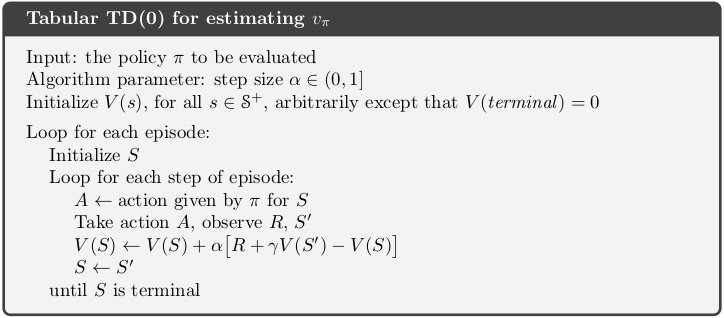


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from collections import defaultdict
import gym  # blacjack

### Implementation of TD(0)

Start by filling the following blanks in the code below:

In [4]:
def td_prediction(env, policy, ep, gamma, alpha):
    """TD Prediction

    Params:
        env - environment
        ep - number of episodes to run
        policy - function in form: policy(state) -> action
        gamma - discount factor [0..1]
        alpha - step size (0..1]
    """
    assert 0 < alpha <= 1
    V = defaultdict(float)    # default value 0 for all states

    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S) # YOUR CODE HERE #
            S_, R, done = env.step(A) # YOUR CODE HERE #
            V[S] = V[S] + alpha * (R + gamma * V[S_] - V[S]) # YOUR CODE HERE #
            S = S_ # YOUR CODE HERE #
            if done: break

    return V

For TD prediction to work, **V for terminal states must be equal to
zero, always**. Value of terminal states is zero because game is over
and there is no more reward to get. Value of next-to-last state is
reward for last transition only, and so on.

-   If terminal state is initalised to something different than zero,
    then your resulting V estimates will be offset by that much
-   If, V of terminal state is *updated during training*
    then everything will go wrong.
    -   so make *absolutely sure* environment returns different
        observations for terminal states than non-terminal ones
    -   hint: this is not the case for out-of-the-box gym Blackjack, so you need to change it

## Evaluate a Random walk (example 6.2 Sutton's book)

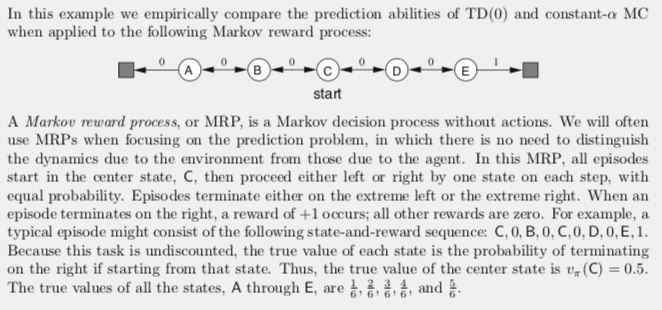

In [5]:
class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self._state = 3
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')

        if action == 0: self._state -= 1
        if action == 1: self._state += 1
            
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
                
        return self._state, reward, self._done  # obs, rew, done

In [6]:
env = LinearEnv()

Plotting helper function:

In [7]:
def plot(V_dict):
    """Param V is dictionary int[0..7]->float"""
    
    V_arr = np.zeros(7)
    for st in range(7):
        V_arr[st] = V_dict[st]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LinearEnv.V_true[1:-1], color='black', label='V true')
    ax.plot(V_arr[1:-1], label='V')
    
    ax.legend()
    
    plt.show()

Random policy:

In [8]:
def policy(state):
    return np.random.choice([0, 1])  # random policy

#### For 10 episodes

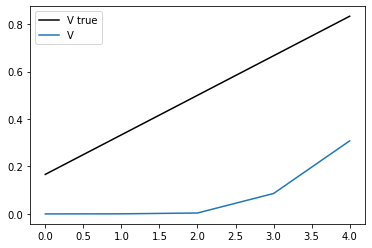

In [9]:
V = td_prediction(env, policy, ep=10, gamma=1.0, alpha=0.1)
plot(V)

#### For 1000 episodes 

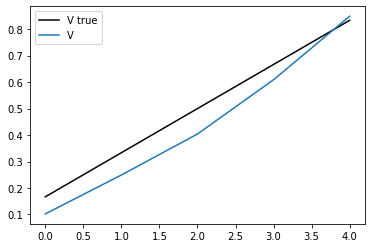

In [11]:
V = td_prediction(env, policy, ep=1000, gamma=1.0, alpha=0.1)
plot(V)

## Temporal-Difference for BlackJack

Let's start first by fixing the BlackJack environement for TD(0)

As mentioned earlier, there is a problem with Blackjack environment in the gym. If agent sticks, then environment will return exactly the same observation but this time with done==True. This will cause TD prediction to evaluate terminal state to non-zero value belonging to non-terminal state with same observation. We fix this by redefining observation for terminal states with 'TERMINAL'.


In [12]:
class BlackjackFixed():
    def __init__(self):
        self._env = gym.make('Blackjack-v0')
        
    def reset(self):
        return self._env.reset()
    
    def step(self, action):
        obs, rew, done, _ = self._env.step(action)
        if done:
            return 'TERMINAL', rew, True  # (obs, rew, done)         <-- SUPER IMPORTANT!!!!
        else:
            return obs, rew, done
        return self._env.step(action)

In [13]:
env = BlackjackFixed()

Naive policy for BlackJack. We keep the same as earlier: stick on 20 or more, hit otherwise.

In [15]:
def policy(St):
    p_sum, d_card, p_ace = St
    if p_sum >= 20:
        return 0  # don't hit when p_sum is equal or larger than 20
    else:
        return 1  # otherwise, hit
    # YOUR CODE HERE # 
    # Write the if statement for the policy, return 1 for a hit action and 0 for stick action # 

Plotting

In [16]:
def plot_blackjack(V_dict):
    def convert_to_arr(V_dict, has_ace):
        V_dict = defaultdict(float, V_dict)  # assume zero if no key
        V_arr = np.zeros([10, 10])  # Need zero-indexed array for plotting 
        for ps in range(12, 22):     # convert player sum from 12-21 to 0-9
            for dc in range(1, 11):  # convert dealer card from 1-10 to 0-9
                V_arr[ps-12, dc-1] = V_dict[(ps, dc, has_ace)]
        return V_arr

    def plot_3d_wireframe(axis, V_dict, has_ace):
        Z = convert_to_arr(V_dict, has_ace)
        dealer_card = list(range(1, 11))
        player_points = list(range(12, 22))
        X, Y = np.meshgrid(dealer_card, player_points)
        axis.plot_wireframe(X, Y, Z)

    fig = plt.figure(figsize=[16,3])
    ax_no_ace = fig.add_subplot(121, projection='3d', title='No Ace')
    ax_has_ace = fig.add_subplot(122, projection='3d', title='With Ace')
    ax_no_ace.set_xlabel('Dealer Showing'); ax_no_ace.set_ylabel('Player Sum')
    ax_has_ace.set_xlabel('Dealer Showing'); ax_has_ace.set_ylabel('Player Sum')
    plot_3d_wireframe(ax_no_ace, V_dict, has_ace=False)
    plot_3d_wireframe(ax_has_ace, V_dict, has_ace=True)
    plt.show()

Evaluate

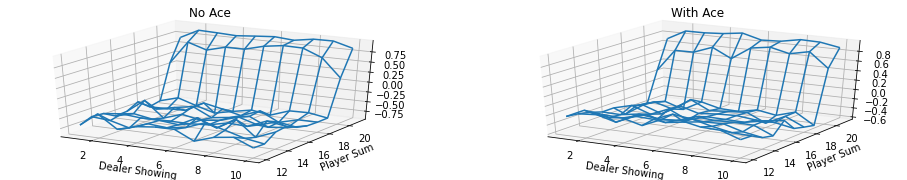

In [17]:
V = td_prediction(env, policy, ep=50000, gamma=1.0, alpha=0.05)
plot_blackjack(V)

## TD vs MC comparison on Random Walk

We will need slightly extended version of TD prediction, so we can log V during training and initalise V to 0.5



In [20]:
def td_prediction_ext(env, policy, ep, gamma, alpha, V_init=None):
    """TD Prediction
    
    Params:
        env - environment
        ep - number of episodes to run
        policy - function in form: policy(state) -> action
        gamma - discount factor [0..1]
        alpha - step size (0..1]
    """
    assert 0 < alpha <= 1
    
    # Change #1, allow initialisation to arbitrary values
    if V_init is not None:  V = V_init.copy()       # remember V of terminal states must be 0 !!
    else:                   V = defaultdict(float)  # default value 0 for all states
    
    V_hist = []
    
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S) # YOUR CODE HERE #
            S_, R, done = env.step(A) # YOUR CODE HERE #
            V[S] = V[S] + alpha * (R + gamma * V[S_] - V[S]) # YOUR CODE HERE #
            S = S_ # YOUR CODE HERE #
            if done: break
        
        V_arr = [V[i] for i in range(7)]  # e.g. [0.0, 0.3, 0.4, 0.5, 0.6. 0.7, 0.0]
        V_hist.append(V_arr)  # dims: [ep_number, state]
                
    return V, np.array(V_hist)

Environment and policy

In [21]:
env = LinearEnv()

In [22]:
def policy(state):
    return np.random.choice([0, 1])  # random policy

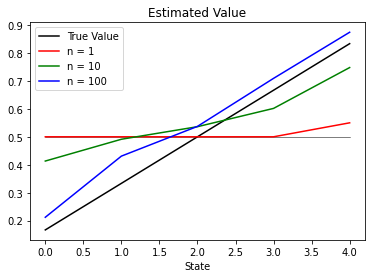

In [23]:
V_init = defaultdict(lambda: 0.5)   # init V to 0.5
V_init[0] = V_init[6] = 0.0         # but terminal states to zero !!
V_n1, _ = td_prediction_ext(env, policy, ep=1, gamma=1.0, alpha=0.1, V_init=V_init)
V_n10, _ = td_prediction_ext(env, policy, ep=10, gamma=1.0, alpha=0.1, V_init=V_init)
V_n100, _ = td_prediction_ext(env, policy, ep=100, gamma=1.0, alpha=0.1, V_init=V_init)

def to_arr(V_dict):
    """Param V is dictionary int[0..7]->float"""
    V_arr = np.zeros(7)
    for st in range(7):
        V_arr[st] = V_dict[st]
    return V_arr

V_n1 = to_arr(V_n1)
V_n10 = to_arr(V_n10)
V_n100 = to_arr(V_n100)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.zeros([7])[1:-1]+0.5, color='black', linewidth=0.5)
ax.plot(LinearEnv.V_true[1:-1], color='black', label='True Value')
ax.plot(V_n1[1:-1], color='red', label='n = 1')
ax.plot(V_n10[1:-1], color='green', label='n = 10')
ax.plot(V_n100[1:-1], color='blue', label='n = 100')
ax.set_title('Estimated Value')
ax.set_xlabel('State')
ax.legend()

# plt.savefig('assets/fig_0601a')
plt.show()

### Question: 
Interpret the graph above.

Answer:

The more episodes the updated td algorithm has, the closer it is to converge to the true value. The random walk has been able to add more exploration to the agent's behavior which helps it find the actions that lead closer to the true value

## We define a running mean MC algorithm. 

In [24]:
def mc_prediction_ext(env, policy, ep, gamma, alpha, V_init=None):
    """Running Mean MC Prediction
    Params:
        env - environment
        policy - function in a form: policy(state)->action
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1)
        V_init - inial V
    """
    if V_init is not None:  V = V_init.copy()
    else:                   V = defaultdict(float)  # default value 0 for all states
    
    V_hist = []
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            V[St] = V[St] + alpha * (G - V[St])
            
        V_arr = [V[i] for i in range(7)]  # e.g. [0.0, 0.3, 0.4, 0.5, 0.6. 0.7, 0.0]
        V_hist.append(V_arr)  # dims: [ep_number, state]
        
    return V, np.array(V_hist)

In [25]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

For each line on a plot, we need to run algorithm multitple times and then calculate root-mean-squared-error over all runs properly. Let's define helper function to do all that.



In [26]:
def run_experiment(algorithm, nb_runs, env, ep, policy, gamma, alpha):
    V_init = defaultdict(lambda: 0.5)   # init V to 0.5
    V_init[0] = V_init[6] = 0.0         # but terminal states to zero !!

    V_runs = []
    for i in range(nb_runs):
        _, V_hist = algorithm(env, policy, ep, gamma=gamma, alpha=alpha, V_init=V_init)
        V_runs.append(V_hist)
    V_runs = np.array(V_runs)  # dims: [nb_runs, nb_episodes, nb_states=7]
    
    V_runs = V_runs[:,:,1:-1]  # remove data about terminal states (which is always zero anyway)
    error_to_true = V_runs - env.V_true[1:-1]
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)  # avg over states
    root_mean_squared_error = np.sqrt(mean_squared_error)
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs  # this is data that goes directly on the plot

And finally the experiments

In [27]:
#                                             nb_runs      ep         gamma alpha
rmse_td_a15 = run_experiment(td_prediction_ext, 100, env, 100, policy, 1.0, 0.15)
rmse_td_a10 = run_experiment(td_prediction_ext, 100, env, 100, policy, 1.0, 0.10)
rmse_td_a05 = run_experiment(td_prediction_ext, 100, env, 100, policy, 1.0, 0.05)
rmse_mc_a04 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.04)
rmse_mc_a03 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.03)
rmse_mc_a02 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.02)
rmse_mc_a01 = run_experiment(mc_prediction_ext, 100, env, 100, policy, 1.0, 0.01)

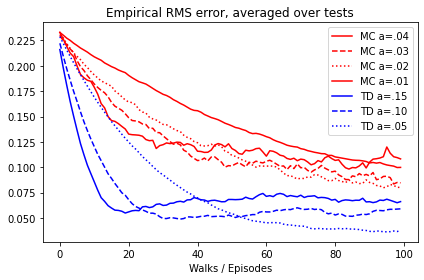

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rmse_mc_a04, color='red', linestyle='-', label='MC a=.04')
ax.plot(rmse_mc_a03, color='red', linestyle='--', label='MC a=.03')
ax.plot(rmse_mc_a02, color='red', linestyle=':', label='MC a=.02')
ax.plot(rmse_mc_a01, color='red', linestyle='-', label='MC a=.01')
ax.plot(rmse_td_a15, color='blue', linestyle='-', label='TD a=.15')
ax.plot(rmse_td_a10, color='blue', linestyle='--', label='TD a=.10')
ax.plot(rmse_td_a05, color='blue', linestyle=':', label='TD a=.05')
ax.set_title('Empirical RMS error, averaged over tests')
ax.set_xlabel('Walks / Episodes')
ax.legend()
plt.tight_layout()
# plt.savefig('assets/fig_0601b.png')
plt.show()

### Question
Interpret the graph above.

Answer:

In general, TD is better than MC algorithm in terms of lower RMS error from the beginning til the end. For TD, as the influence of the latest action decreased (alpha decreased), the performance converged closer to the true value. It means a large alpha will make the agent pay too much attention on the newest rewards and it seems not good.

From the graph we can see that, MC performs so poor with it has a large alpha. It is understandable because it is model free.

Moreover, since the TD can learn directly from experiences and can learn before knowing the outcome, it can outperform MC. Nevertheless, TD does have low variance but some bias, while MC has zero bias and higher variance. TD also is dependent on initial value, evident from its different expectations near the initials walks